<a href="https://colab.research.google.com/github/condor68mihon/InformationTheory/blob/master/InformationTheory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Теория информации

# Новый раздел

# Новый раздел

# Новый раздел

In [ ]:
# !pip install feature_engine

In [ ]:
import numpy as np
import pandas as pd
np.set_printoptions(legacy='1.25')
import math
from scipy.stats import entropy
import matplotlib.pyplot as plt
from collections import Counter
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest
import tensorflow as tf
import tensorflow_probability as tfp

## Информационная энтропия

In [ ]:
def calculate_entropy(pk):
  return -sum([p * np.log2(p) for p in pk])

In [ ]:
language_1 = [0.25, 0.25, 0.25, 0.25]
language_2 = [0.5, 0.25, 0.125, 0.125]

In [ ]:
calculate_entropy(language_1), calculate_entropy(language_2)

(2.0, 1.75)

In [ ]:
print(entropy(language_1, base=2), entropy(language_2, base=2))

2.0 1.75


## Код Хаффмана

In [ ]:
class NodeTree():
  '''
  Класс узла дерева
  '''
  def __init__(self, left=None, right=None):
    self.left = left
    self.right = right

  def children(self):
    return self.left, self.right

def calculate_frequencies(string: str) -> list:
  '''
  Рассчитывает частоты символов в строке
  :param string: строка символов
  :return list: список частот в виде кортежей (символ, частота)
  '''
  # создадим словарь, где ключами будут уникальные символы, а
  # значениями - соответствующие частоты
  freq = dict(Counter(string))
  # отсортируем по значению в убывающем порядке
  freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
  return freq

def huffman_tree(nodes: list) -> NodeTree:
  '''
  Создает бинарное дерево с учетом частоты символов
  :param list: список частот в виде кортежей
  :return NodeTree: объект класса NodeTree
  '''
  # пока количество использованных символов больше одного
  # (другими словами, пока дерево не построено)
  while len(nodes) > 1:
    # возьмем последние два символа и их частоту
    (key1, c1) = nodes[-2]
    (key2, c2) = nodes[-1]
    # удалим эти символы
    nodes = nodes[:-2]
    # создадим объект класса узла дерева,
    # используя ключи этих символов
    node = NodeTree(key1, key2)
    # новым значением будет сумма их частот
    node_value = c1 + c2
    # добавим новый узел и его частоту в конец списка
    # вместо двух удаленных символов
    nodes.append((node, node_value))
    # отсортируем по значению
    nodes = sorted(nodes, key=lambda x: x[1], reverse=True)

  # вернем корневой узел дерева, содержащий в себе объекты-потомки
  return nodes[0][0]

def huffman_code(node: NodeTree, binString: str='') -> list:
  '''
  Выполняет кодирование символов
  '''
  # будем рекурсивно обращаться к узлам дерева
  # если дойдем до терминальной вершины, являющейся строкой,
  if type(node) is str:
    # вернем символ и соответствующий код
    return {node: binString}

  # пока же мы не дошли до конца дерева, будем "доставать" потомков
  # из очередного узла дерева,
  (l, r) = node.children()
  # одновременно формируя словарь,
  d = dict()
  # в котором каждый левый потомок получает код 0, а правый - 1
  d.update(huffman_code(l, binString + '0'))
  d.update(huffman_code(r, binString + '1'))
  # наконец отсортируем словарь по значениям в лексикографическом порядке
  d = sorted(d.items(), key=lambda x: x[1])
  return d

кодирование языка 1

In [ ]:
language_1 = 25 * 'C' + 25 * 'D' + 25 * 'A' + 25 * 'B'
freq = calculate_frequencies(language_1)
tree = huffman_tree(freq)
encoding = huffman_code(tree)
encoding

[('A', '00'), ('B', '01'), ('C', '10'), ('D', '11')]

кодирование языка 2

In [ ]:
language_2 = 500 * 'A' + 250 * 'B' + 125 * 'C' + 125 * 'D'
freq = calculate_frequencies(language_2)
tree = huffman_tree(freq)
encoding = huffman_code(tree)
encoding

[('A', '0'), ('B', '10'), ('C', '110'), ('D', '111')]

## Бинарная энтропия

In [ ]:
@np.vectorize
def binary_entropy(p):
  if p == 0 or p == 1:
    return 0.0
  return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

In [ ]:
P = np.linspace(0, 1, 100)
H = binary_entropy(P)

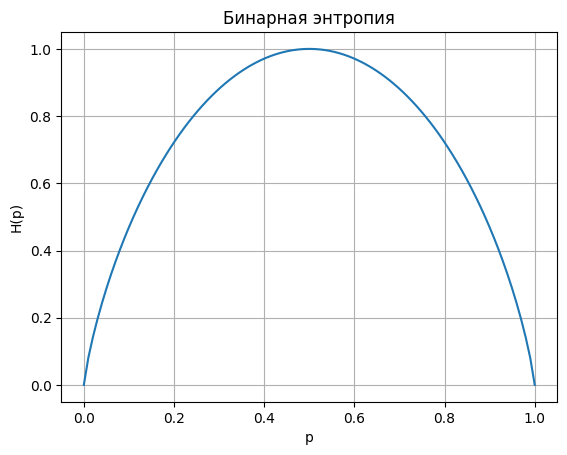

In [ ]:
plt.plot(P, H)
plt.xlabel('p')
plt.ylabel('H(p)')
plt.title('Бинарная энтропия')
plt.grid()
plt.show()

## Совместная энтропия

In [ ]:
# для вычислительной устойчивости
# заменим ноль на небольшое положительное число
freq = np.array([[3, 2], [4, 1e-10], [2, 3]])

In [ ]:
p = np.sum(freq, axis=1)/np.sum(freq)
H_x = -np.sum(p * np.log2(p))

p = np.sum(freq, axis=0)/np.sum(freq)
H_y = -np.sum(p * np.log2(p))

H_x, H_y

(1.5774062828539877, 0.9402859586745249)

In [ ]:
H_xy = 0
for x in range(freq.shape[0]):
  for y in range(freq.shape[1]):
    p_xy = freq[x, y] / np.sum(freq)
    H_xy -= p_xy * np.log2(p_xy)
H_xy

2.270942422007097

## Взаимная информация

In [ ]:
I_xy = 0
for x in range(freq.shape[0]):
  for y in range(freq.shape[1]):
    p_xy = freq[x, y] / np.sum(freq)
    p_x = np.sum(freq[x, :]) / np.sum(freq)
    p_y = np.sum(freq[:, y]) / np.sum(freq)
    pmi = np.log2(p_xy / (p_x * p_y))
    I_xy += p_xy * pmi
I_xy

0.2467498195214155

In [ ]:
H_x + H_y - H_xy == I_xy

True

In [ ]:
from sklearn.metrics import mutual_info_score
# функция mutual_info_score() рассчитывает информацию в натах
# для преобразования в биты, умножим на log2(e)
mutual_info_score(labels_true=None,
                  labels_pred=None,
                  contingency = freq) * np.log2(np.e)

0.2467498197744392

In [ ]:
X1 = ['a', 'b', 'a', 'b', 'a', 'b']
Y1 = ['b', 'a', 'b', 'a', 'b', 'a']

In [ ]:
from scipy.stats.contingency import crosstab
c = crosstab(X1, Y1)
(mutual_info_score(labels_true=None,
                   labels_pred=None,
                   contingency = c[1]) * np.log2(np.e)).round()

1.0

In [ ]:
X1_probs = np.array([Counter(X1)['a'], Counter(X1)['b']])/len(X1)
X1_probs

array([0.5, 0.5])

In [ ]:
calculate_entropy(X1_probs)

1.0

In [ ]:
X2 = ['a', 'a', 'a', 'a', 'a', 'a']
Y2 = ['b', 'a', 'b', 'a', 'b', 'a']
c = crosstab(X2, Y2)
(mutual_info_score(labels_true=None,
                   labels_pred=None,
                   contingency = c[1]) * np.log2(np.e)).round()

0.0

### Отбор признаков

Подготовка данных

In [ ]:
titanic = pd.read_csv('/content/train.csv')

In [ ]:
titanic.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

In [ ]:
titanic.dropna(subset=['Embarked', 'Fare'], inplace=True)
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].mean())

In [ ]:
def get_first_cabin(row):
  try:
    return row.split()[0]
  except:
    return 'N'

In [ ]:
titanic['Cabin'] = titanic['Cabin'].apply(get_first_cabin).str[0]
encoder = RareLabelEncoder(variables='Cabin', n_categories=2)
titanic = encoder.fit_transform(titanic)

In [ ]:
encoder = OrdinalEncoder(
                encoding_method='arbitrary',
                variables=['Sex', 'Cabin', 'Embarked'],
                )
titanic = encoder.fit_transform(titanic)

In [ ]:
titanic.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0,22.0,1,0,7.2500,0,0
1,1,1,1,38.0,1,0,71.2833,1,1
2,1,3,1,26.0,0,0,7.9250,0,0


Расчет взаимной информации

In [ ]:
# параметр discrete_features=[True] указывает на то, что признак (Sex)
# также дискретен
mutual_info_classif(titanic['Sex'].to_frame(), titanic['Pclass'],
                    discrete_features=[True])

array([0.0090587])

In [ ]:
# возьмем непрерывный признак (Fare)
mutual_info_classif(titanic['Fare'].to_frame(), titanic['Pclass'],
                    discrete_features=[False])

array([0.82689302])

In [ ]:
mutual_info_regression(titanic['Fare'].to_frame(), titanic['Age'],
                       discrete_features=[False])

array([0.15307641])

In [ ]:
X, y = titanic.iloc[:, 1:], titanic.iloc[:, 0]
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked'], dtype='object')

In [ ]:
discrete_features = [True, True, False, True, True, False, True, True]

In [ ]:
np.random.seed(42)
mi = mutual_info_classif(X, y, discrete_features=discrete_features)

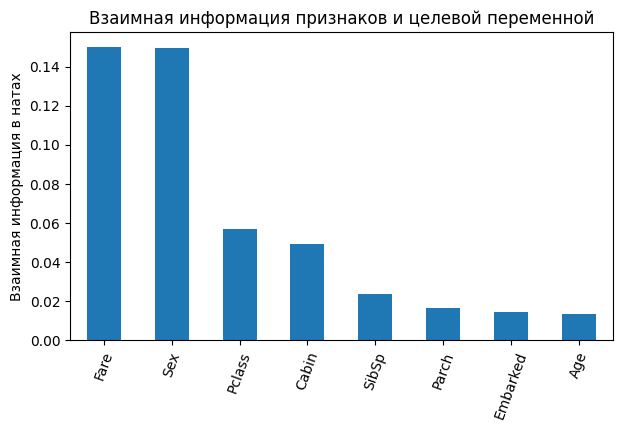

In [ ]:
mi = pd.Series(mi)
mi.index = X.columns
mi.sort_values(ascending=False).plot.bar(figsize=(7, 4))
plt.ylabel('Взаимная информация в натах')
plt.title('Взаимная информация признаков и целевой переменной')
plt.xticks(rotation=70)
plt.show()

Отбор признаков на основе взаимной информации

In [ ]:
np.random.seed(42)
# для отбора на основе взаимной информации передадим mutual_info_classif
sel = SelectKBest(mutual_info_classif, k=4).fit(X, y)
X = sel.transform(X)

In [ ]:
sel.get_feature_names_out()

array(['Pclass', 'Sex', 'Fare', 'Cabin'], dtype=object)

In [ ]:
X = pd.DataFrame(X, columns=sel.get_feature_names_out())
X.head(3)

,Pclass,Sex,Fare,Cabin
0,3.0,0.0,7.2500,0.0
1,1.0,1.0,71.2833,1.0
2,3.0,1.0,7.9250,0.0


### Квартет Энскомба

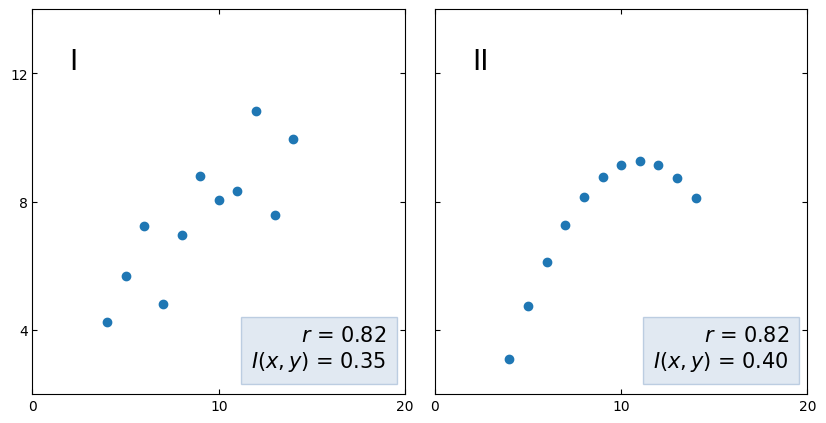

In [ ]:
np.random.seed(1)
anscombe = pd.read_json('/content/sample_data/anscombe.json')
series_by_group = [x for _, x in anscombe.groupby('Series')]
labels = anscombe.Series.unique()
datasets = {}

for label, series in zip(labels, series_by_group):
  if label == 'I' or label == 'II':
    datasets[label] = (list(series.X.round(2)), list(series.Y.round(2)))

fig, axs = plt.subplots(1, 2,
                        sharex = True,
                        sharey = True,
                        figsize = (10, 5),
                        gridspec_kw = {'wspace': 0.08, 'hspace': 0.08})

axs[0].set(xlim = (0, 20), ylim = (2, 14))
axs[1].set(xticks = (0, 10, 20), yticks = (4, 8, 12))

for ax, (label, (x, y)) in zip(axs.flat, datasets.items()):

    ax.text(0.1, 0.9, label, fontsize = 20, transform = ax.transAxes, va = 'top')
    ax.tick_params(direction = 'in', top = True, right = True)

    ax.scatter(x, y)

    # рассчитаем корреляцию Пирсона и взаимную информацию
    stats = (f'$r$ = {np.corrcoef(x, y)[0][1]:.2f}\n'
             f'$I(x,y)$ = {mutual_info_regression(pd.Series(x).to_frame(), pd.Series(y), discrete_features=[False])[0]:.2f}')

    bbox = dict(boxstyle = 'square', pad = 0.5,
                fc = '#c5d4e6',
                ec = '#89a8cc',
                alpha = 0.5)

    ax.text(0.95, 0.07, stats, fontsize = 15,
            bbox = bbox, transform = ax.transAxes,
            horizontalalignment = 'right')

plt.show()

## Условная энтропия

In [ ]:
H_y_given_x = 0
for x in range(freq.shape[0]):
  p_x = np.sum(freq[x]) / np.sum(freq)
  p_y_given_x = freq[x] / np.sum(freq[x])
  H_y_given_x -= p_x * np.sum(p_y_given_x * np.log2(p_y_given_x))
H_y_given_x

0.6935361391531092

## Перекрестная энтропия

кодирование языков p и q

In [ ]:
language_p = 50 * 'A' + 25 * 'B' + 25 * 'C'
freq = calculate_frequencies(language_p)
tree = huffman_tree(freq)
encoding = huffman_code(tree)
encoding

[('A', '0'), ('B', '10'), ('C', '11')]

In [ ]:
language_q = 25 * 'A' + 50 * 'B' + 25 * 'C'
freq = calculate_frequencies(language_q)
tree = huffman_tree(freq)
encoding = huffman_code(tree)
encoding

[('B', '0'), ('A', '10'), ('C', '11')]

расчет перекрестной энтропии

In [ ]:
p = [1/2, 1/4, 1/4]
q = [1/4, 1/2, 1/4]

In [ ]:
def cross_entropy(p, q):
  return -np.dot(np.array(p), np.log2(np.array(q)))

In [ ]:
cross_entropy(p, q)

1.75

функция потерь

In [ ]:
p = [0, 1]
q = [0.2, 0.8]

# log_loss использует натуральный логарифм
from sklearn.metrics import log_loss

def cross_entropy_loss(p,q):
  return -np.dot(np.array(p), np.log(np.array(q)))

log_loss(p,q), cross_entropy_loss(p,q)

(0.2231435513142097, 0.2231435513142097)

несимметриченость перекрестной энтропии

In [ ]:
a = [0.1, 0.9]
b = [0.7, 0.3]

cross_entropy(a,b), cross_entropy(b,a)

(1.6147263520325614, 2.3709505944546683)

приближение перекрестной энтропии

In [ ]:
p = [0.1, 0.9]
q = [0.7, 0.3]

cross_entropy_loss(p,q)

1.1192430182872157

In [ ]:
px = tfp.distributions.Bernoulli(probs=0.1)
px_sample = px.sample(100000)

In [ ]:
qx = tfp.distributions.Bernoulli(probs=0.7)

In [ ]:
-tf.reduce_mean(tf.math.log(qx.prob(px_sample)))

<tf.Tensor: shape=(), dtype=float32, numpy=1.118897557258606>

In [ ]:
qx.prob(px_sample)[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.29999998, 0.29999998, 0.29999998, 0.7       , 0.29999998,
       0.29999998, 0.29999998, 0.29999998, 0.29999998, 0.7       ],
      dtype=float32)>

## Дивергенция Кульбака-Лейблера

In [ ]:
p = [1/2, 1/4, 1/4]
q = [1/4, 1/2, 1/4]

entropy(p, q, base=2)

0.25

приближение дивергенции Кульбака-Лейблера

In [ ]:
p = [0.1, 0.9]
q = [0.7, 0.3]

entropy(p, q)

0.7941600448957675

In [ ]:
px = tfp.distributions.Bernoulli(probs=0.1)
qx = tfp.distributions.Bernoulli(probs=0.7)

tfp.distributions.kl_divergence(px, qx)

<tf.Tensor: shape=(), dtype=float32, numpy=0.794160008430481>

In [ ]:
# help(tfp.distributions.kl_divergence)

In [ ]:
p = [1/2, 1/4, 1/4]
q = [1/4, 1/2, 1/4]

entropy(p, q)

0.17328679513998632

In [ ]:
px = tfp.distributions.Multinomial(total_count=1, probs=p)
qx = tfp.distributions.Multinomial(total_count=1, probs=q)

In [ ]:
px = tfp.distributions.Categorical(probs=p)
qx = tfp.distributions.Categorical(probs=q)

In [ ]:
px_sample = px.sample(200000)

In [ ]:
tf.reduce_mean(tf.math.log(px.prob(px_sample) / qx.prob(px_sample)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.17174458503723145>

In [ ]:
tf.reduce_mean(px.log_prob(px_sample) - qx.log_prob(px_sample))

<tf.Tensor: shape=(), dtype=float32, numpy=0.17174458503723145>

In [ ]:
tfp.vi.monte_carlo_variational_loss(qx.log_prob,px,200000,
                                    gradient_estimator=tfp.vi.GradientEstimators.SCORE_FUNCTION)

<tf.Tensor: shape=(), dtype=float32, numpy=0.1719629317522049>

## Дивергенция Йенсена-Шеннона

In [ ]:
def jensen_shannon_divergence(P, Q):

  P = np.asarray(P)
  Q = np.asarray(Q)

  M = 0.5 * (P + Q)

  kl_pm = entropy(P, M, base=2)
  kl_qm = entropy(Q, M, base=2)

  return 0.5 * (kl_pm + kl_qm)

In [ ]:
p = [0.1, 0.4, 0.5]
q = [0.5, 0.2, 0.3]

In [ ]:
jensen_shannon_divergence(p, q)

0.14773092211916086

## Принцип максимальной энтропии

In [ ]:
from scipy.optimize import newton

a, b, x_bar = 1, 6, 4.5

# (7)
def z(lambda_):
  return 1. / sum(np.exp(-i*lambda_) for i in range(a, b + 1))

# (8)
def f(lambda_):
  numerator = sum(i * np.exp(-i*lambda_) for i in range(a, b + 1))
  return numerator * z(lambda_) - x_bar

# (9)
def p(i, lambda_):
  return z(lambda_) * np.exp(-i * lambda_)

In [ ]:
lambda_ = newton(f, x0=0.5)
for i in range(a, b + 1):
  print("p_%d = %.4f" % (i, p(i, lambda_)))

p_1 = 0.0544
p_2 = 0.0788
p_3 = 0.1142
p_4 = 0.1654
p_5 = 0.2398
p_6 = 0.3475


In [ ]:
x_bar = 3.5

# (8)
def f(lambda_):
  numerator = sum(i * np.exp(-i*lambda_) for i in range(a, b + 1))
  return numerator * z(lambda_) - x_bar

In [ ]:
lambda_ = newton(f, x0=0.5)
for i in range(a, b + 1):
  print("p_%d = %.4f" % (i, p(i, lambda_)))

p_1 = 0.1667
p_2 = 0.1667
p_3 = 0.1667
p_4 = 0.1667
p_5 = 0.1667
p_6 = 0.1667
